# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

10.2.0


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr 14 19:14:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8               3W /  40W |    205MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [5]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

### Ниже в коде добавил функцию, которая делает случайное преобразование над изображением. Приведу демонстрацию возможных преобразований:

In [6]:
image_path = r'train/simpsons_dataset/bart_simpson/pic_0009.jpg'
image = Image.open(image_path)

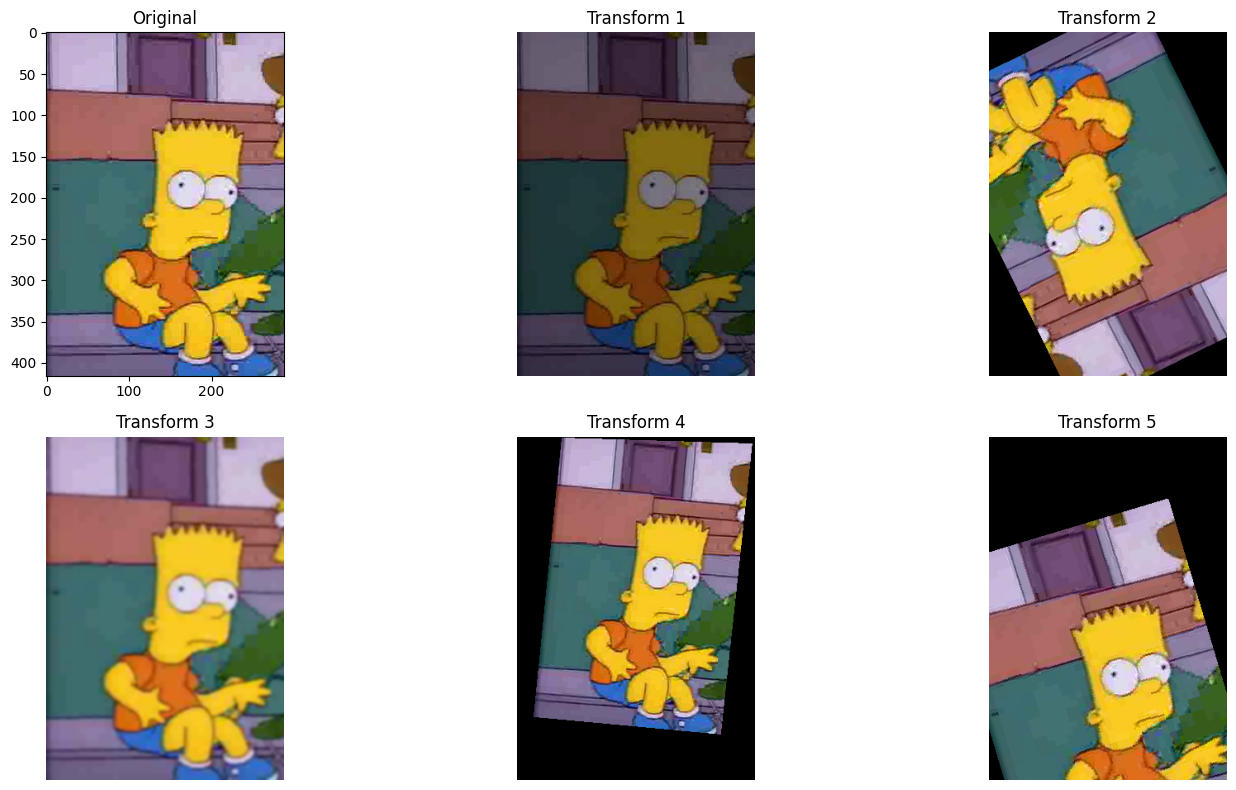

In [7]:
transformations = [
    transforms.Compose([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5)
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=0.15),
        transforms.RandomRotation(degrees=30)
    ]),
    transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.5, 3.0)),
    transforms.RandomPerspective(distortion_scale=0.4, p=1, interpolation=3),
    transforms.RandomAffine(degrees=20, translate=(0.3, 0.3))
]
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.imshow(transforms.ToTensor()(image).numpy().transpose((1, 2, 0)))
plt.title(f'Original')
for i, transform in enumerate(transformations):
    transformed_image = transform(image)
    transformed_tensor = transforms.ToTensor()(transformed_image)
    plt.subplot(2, 3, i+1+1)
    plt.imshow(transformed_tensor.numpy().transpose((1, 2, 0)))
    plt.title(f'Transform {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Напишем функцию, которая возвращает одно из преобразований. Ее сделаем методом класса SimpsonsDataset.

In [8]:
def rand_transform(is_train):
    if not is_train:
        # На валидации или тесте не делаем аугментацию
        return transforms.Lambda(lambda x: x)
    transformations = [
        transforms.Lambda(lambda x: x), # тождественное преобразование
        transforms.Compose([
            transforms.ColorJitter(brightness=0.5),
            transforms.ColorJitter(contrast=0.5)
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.RandomRotation(degrees=30)
        ]),
        transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.5, 2.0)),
        transforms.RandomPerspective(distortion_scale=0.4, p=1, interpolation=3),
        transforms.RandomAffine(degrees=20, translate=(0.3, 0.3))
    ]
    return transforms.RandomChoice(transformations)

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                
###################################################################### 
    def rand_transform(self):
        """
        Функция для аугментации.

        Returns:
            transforms.RandomChoice(): callable объект-трансформация 

        Description:
            Возвращает тождественное преобразование для режима валидации/тетса
            и случайное преобразование для режима тренировки
        """
        
        if self.mode == 'test' or self.mode == 'val':
            # На валидации или тесте не делаем аугментацию
            return transforms.Lambda(lambda x: x)
        transformations = [
            transforms.Compose([
                transforms.ColorJitter(brightness=0.5),
                transforms.ColorJitter(contrast=0.5)
            ]),
            transforms.Compose([
                transforms.RandomHorizontalFlip(p=1),
                transforms.RandomVerticalFlip(p=0.15),
                transforms.RandomRotation(degrees=30)
            ]),
            transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.5, 2.0)),
            transforms.RandomPerspective(distortion_scale=0.4, p=1, interpolation=3),
            transforms.RandomAffine(degrees=20, translate=(0.3, 0.3))
        ]
        return transforms.RandomChoice(transformations)
#######################################################################

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            self.rand_transform(), ############ Добавили одну из возможных транформаций ############
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = Image.fromarray(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
print(len(train_val_files))

20933


In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files,
                                          test_size=0.2,
                                          stratify=train_val_labels,
                                          random_state=42)

In [47]:
val_dataset = SimpsonsDataset(val_files, mode='val')
# Добавление аугментированных изображений к обычным 
train_dataset = torch.utils.data.ConcatDataset([SimpsonsDataset(train_files, mode='train'),
                                                SimpsonsDataset(train_files, mode='val')])
test_dataset = SimpsonsDataset(test_files, mode='test')

Давайте посмотрим на наших героев внутри датасета.

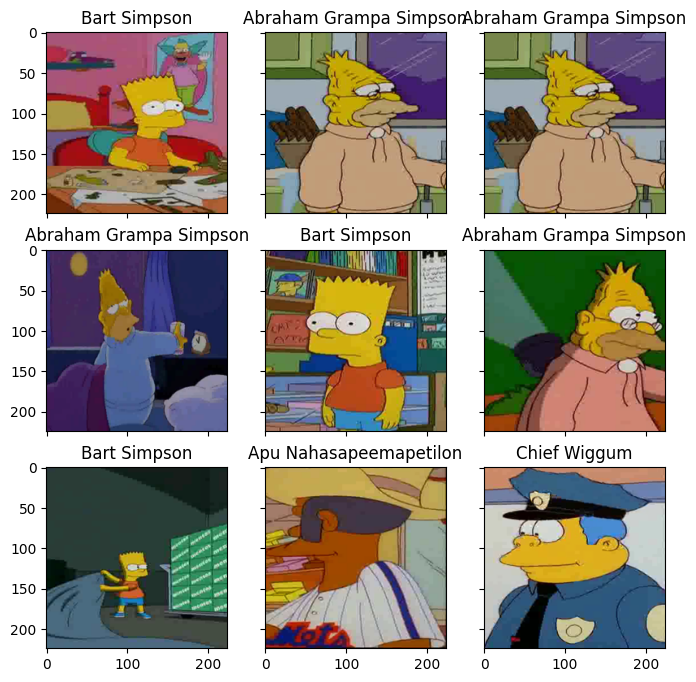

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Посмотрим на распределение классов

In [17]:
classes, classes_counts = np.unique(train_val_labels, return_counts=True)

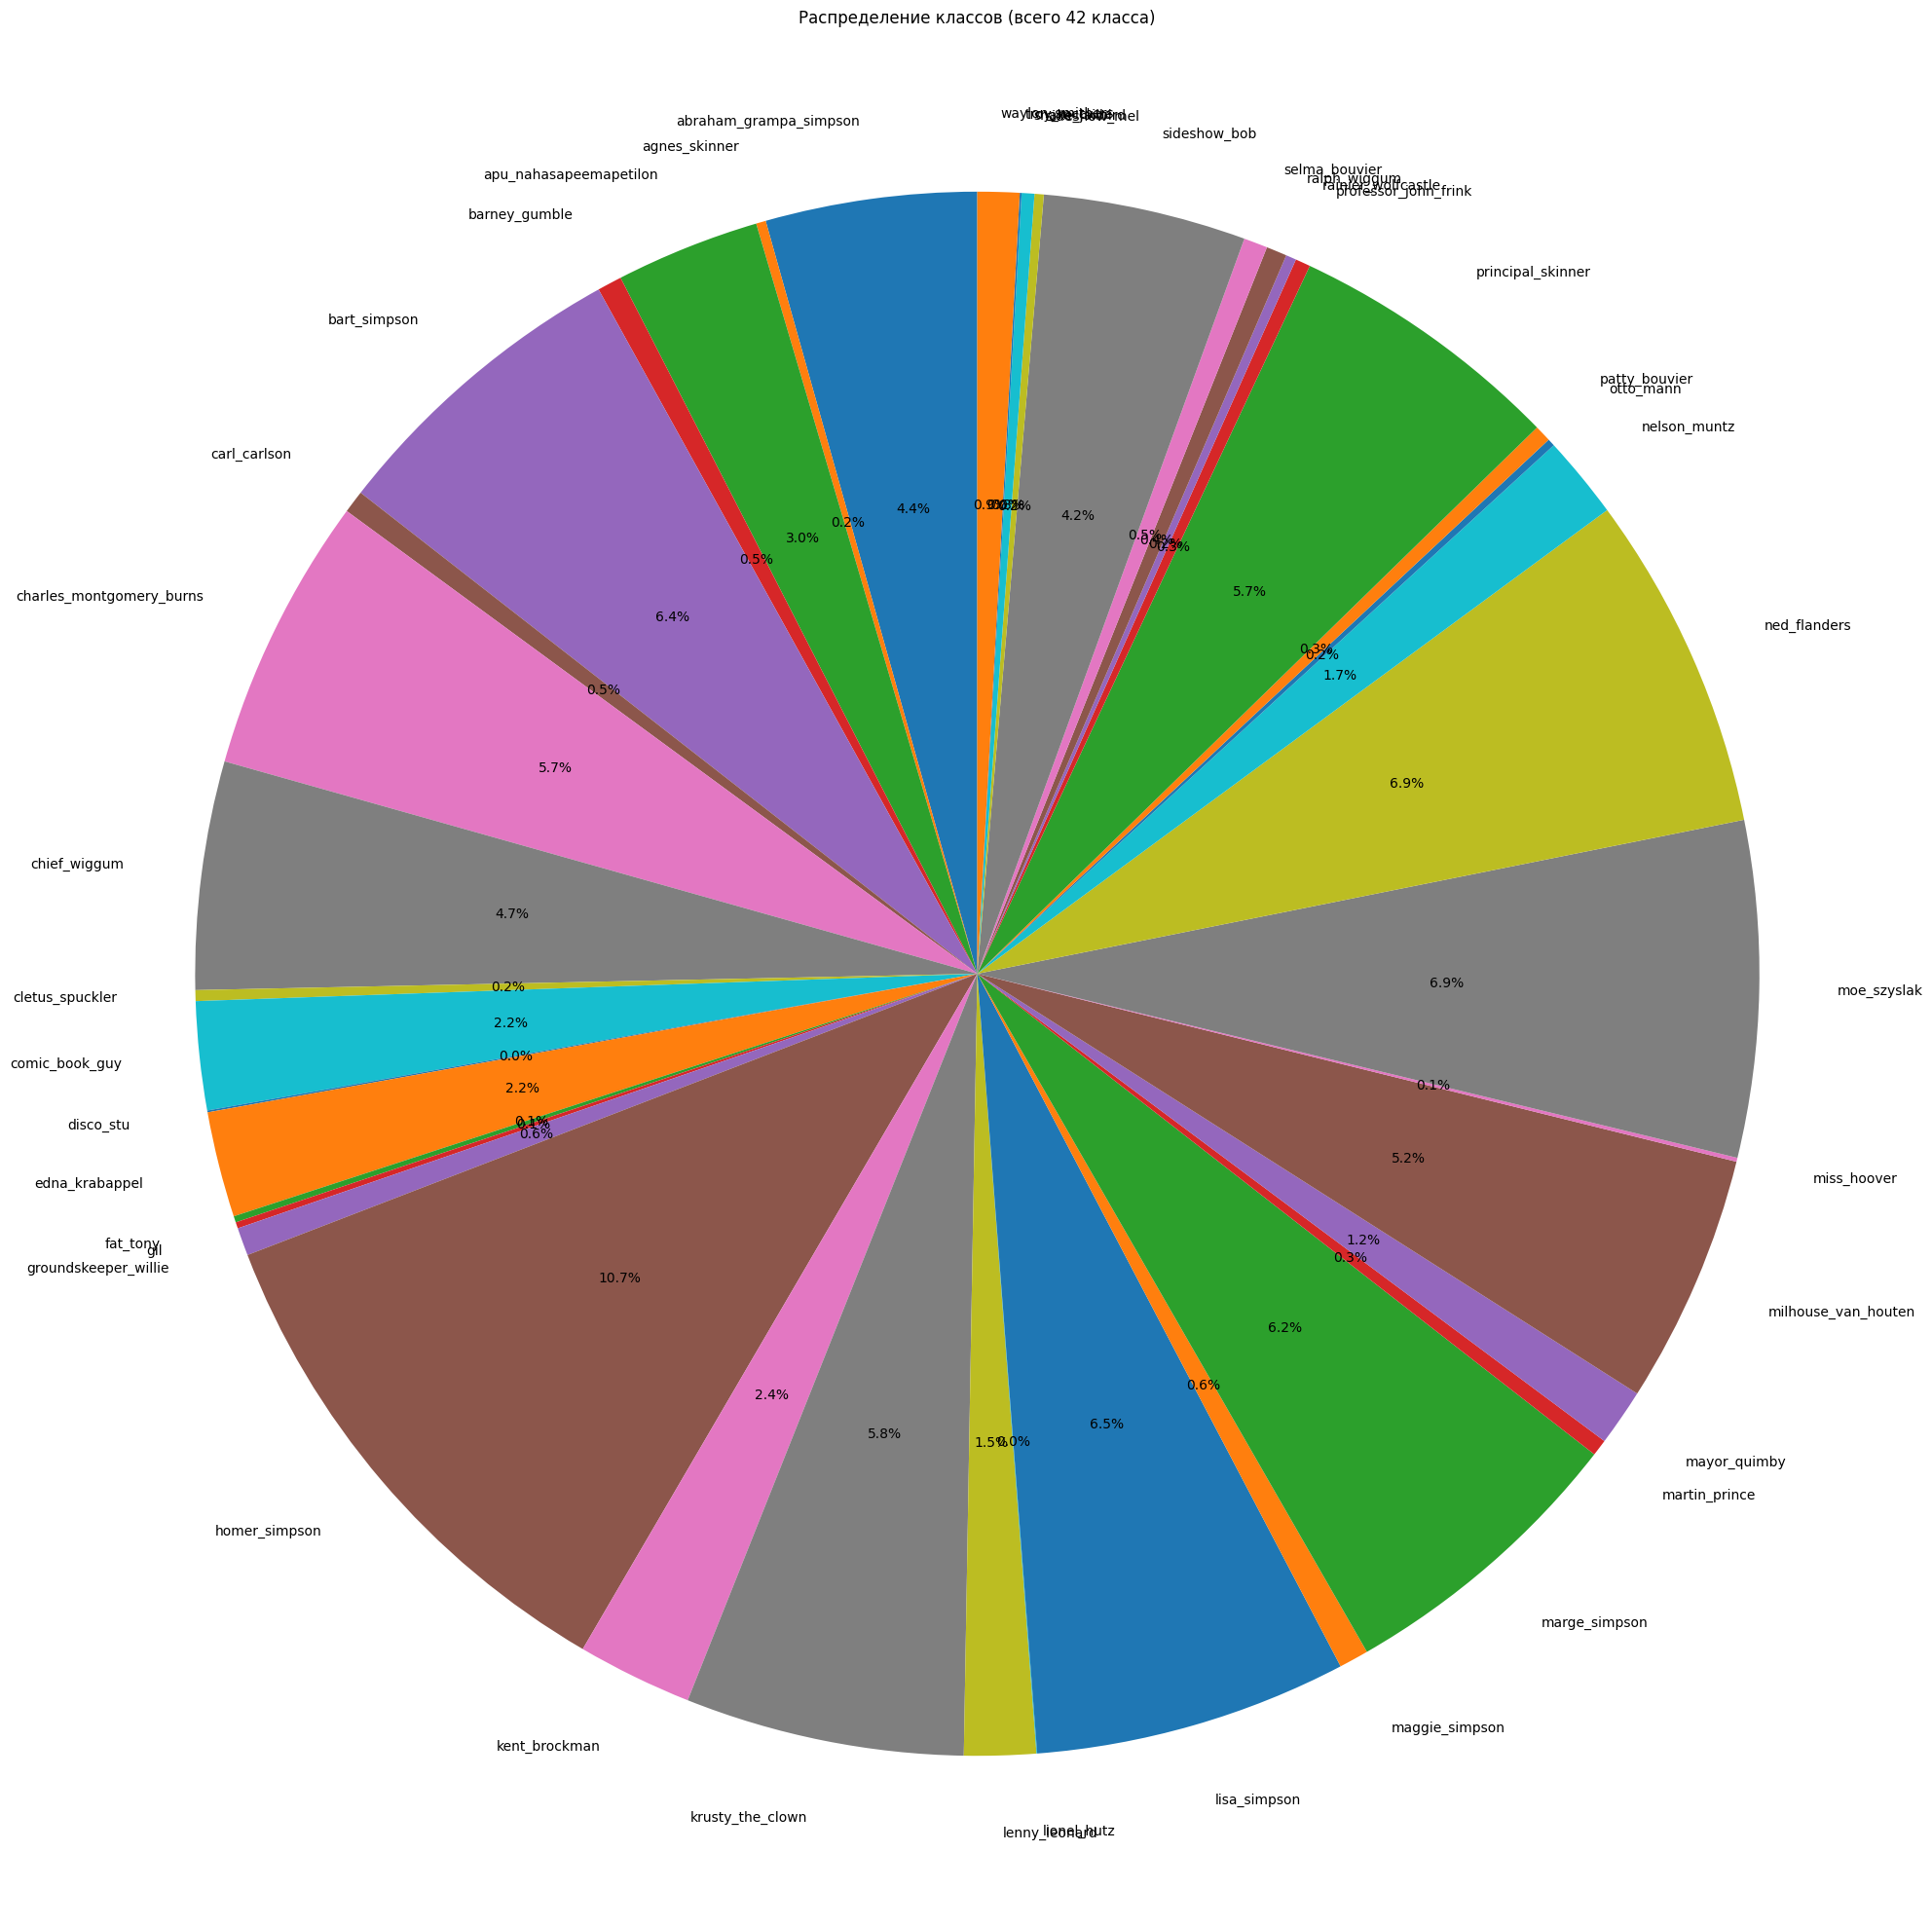

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
ax.pie(classes_counts, labels=classes, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title(f"Распределение классов (всего {len(classes)} класса)")
plt.tight_layout()
plt.show()

**Видим, что классы несбалансированы, присутствуют совсем малопредставленные. Нужно будет с этим бороться.
Далее будем использовать для этих целей WeightedRandomSampler**

**Немного информации о нем здесь:**
- https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
- https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html#WeightedRandomSampler

Суть проста: сэмплируем изображения для обучения с вероятностями, которыми являются их веса. А вес изображения обратно пропорционален частоте встречаемости его класса. Так мы сможем чаще брать для трейна изображения из малопредставленных классов. Если Вы знакомы с NB классификатором и работали с несбалансированными датасетами, то операции downsampling и upsampling должны быть знакомой - без них этот классификатор не сможет хорошо классифицировать малопредставленные классы из-за их низких априорных вероятностей.

Недостаток такого метода - если сэмплировать количество образцов, равное размеру тренировочного датасета, то сэмплер пропустить много изображений, которые у нас есть. Чтобы этого избежать, придется сэмплировать больше, чем размер трейн датасета. Для двух классов можно выбрать 2*len(dataset) сэмплов. В будущем выберем 20 * len(самый представленный класс) сэмплов.

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


### Улучшим представленную сеть. Добавим BN и перед выходом поставим два линейных слоя.

In [19]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16, eps=1e-6, momentum=0.15, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.lin1 = nn.Sequential(
            nn.Linear(in_features=96*5*5, out_features=1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        # self.lin2 = nn.Sequential(
        #     nn.Linear(in_features=1024, out_features=512, bias=True),
        #     nn.BatchNorm1d(512),
        #     nn.ReLU()
        # )
        self.lin3 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.out = nn.Linear(256, n_classes, bias=True)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.lin1(x)
        # x = self.lin2(x)
        x = self.lin3(x)
        logits = self.out(x)
        return logits

### Сделаем измененния в тренировке. Добавим планировщик (scheduler) управления скоростью обучения для оптимизатора.

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    model.eval()

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

### Применим WeightedRandomSampler

In [22]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

In [48]:
def make_weighted_loader(dataset, labels, batch_size):
    """
    Функция для вычисления весов сэмплов.

    Returns:
        DataLoader(): датасет с заданным семплером
    """
    
    label_counts = Counter(labels)
    label_weights = {label: 1.0 / count for label, count in label_counts.items()}
    sample_weights = np.array([label_weights[label] for label in labels])
    num_samples = 20 * max(label_counts.values())
    sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return train_loader

In [24]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = make_weighted_loader(train_dataset,
                                        train_val_labels,
                                        batch_size=batch_size)
    val_loader = make_weighted_loader(val_dataset,
                                      val_dataset.labels,
                                      batch_size)
    
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-06, momentum=0.15, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Запустим обучение сети.

In [27]:
# if val_dataset is None:
#     val_dataset = SimpsonsDataset(val_files, mode='val')

# train_dataset = SimpsonsDataset(train_files, mode='train')

In [28]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=25, batch_size=256)

epoch:   0%|                                                                                    | 0/25 [00:00<?, ?it/s]

loss 1.1092551185420232


epoch:   4%|██▉                                                                      | 1/25 [10:17<4:07:11, 617.97s/it]


Epoch 001 train_loss: 1.1093     val_loss 4.4224 train_acc 0.7107 val_acc 0.2481
loss 0.578179352334431


epoch:   8%|█████▊                                                                   | 2/25 [20:41<3:58:04, 621.07s/it]


Epoch 002 train_loss: 0.5782     val_loss 3.4530 train_acc 0.8473 val_acc 0.3063
loss 0.4446812147926456


epoch:  12%|████████▊                                                                | 3/25 [30:43<3:44:30, 612.29s/it]


Epoch 003 train_loss: 0.4447     val_loss 2.6796 train_acc 0.8805 val_acc 0.4318
loss 0.366283291632696


epoch:  16%|███████████▋                                                             | 4/25 [40:35<3:31:35, 604.56s/it]


Epoch 004 train_loss: 0.3663     val_loss 2.4216 train_acc 0.9015 val_acc 0.4626
loss 0.26869190663550435


epoch:  20%|██████████████▌                                                          | 5/25 [50:21<3:19:16, 597.84s/it]


Epoch 005 train_loss: 0.2687     val_loss 1.9263 train_acc 0.9294 val_acc 0.5518
loss 0.23126244233956


epoch:  24%|█████████████████                                                      | 6/25 [1:00:38<3:11:22, 604.35s/it]


Epoch 006 train_loss: 0.2313     val_loss 1.8295 train_acc 0.9383 val_acc 0.5389
loss 0.22035264786820483


epoch:  28%|███████████████████▉                                                   | 7/25 [1:10:52<3:02:15, 607.55s/it]


Epoch 007 train_loss: 0.2204     val_loss 1.9664 train_acc 0.9412 val_acc 0.5551
loss 0.2064194643539928


epoch:  32%|██████████████████████▋                                                | 8/25 [1:20:34<2:49:49, 599.36s/it]


Epoch 008 train_loss: 0.2064     val_loss 1.7509 train_acc 0.9438 val_acc 0.5932
loss 0.17877561561995495


epoch:  36%|█████████████████████████▌                                             | 9/25 [1:30:21<2:38:49, 595.59s/it]


Epoch 009 train_loss: 0.1788     val_loss 1.4063 train_acc 0.9526 val_acc 0.6657
loss 0.15914546365676346


epoch:  40%|████████████████████████████                                          | 10/25 [1:40:09<2:28:16, 593.11s/it]


Epoch 010 train_loss: 0.1591     val_loss 1.4393 train_acc 0.9574 val_acc 0.6509
loss 0.1481953464959311


epoch:  44%|██████████████████████████████▊                                       | 11/25 [1:49:53<2:17:42, 590.19s/it]


Epoch 011 train_loss: 0.1482     val_loss 1.2959 train_acc 0.9608 val_acc 0.6864
loss 0.14543182388385914


epoch:  48%|█████████████████████████████████▌                                    | 12/25 [1:59:35<2:07:22, 587.88s/it]


Epoch 012 train_loss: 0.1454     val_loss 1.2431 train_acc 0.9616 val_acc 0.6992
loss 0.12554930910030224


epoch:  52%|████████████████████████████████████▍                                 | 13/25 [2:09:18<1:57:17, 586.49s/it]


Epoch 013 train_loss: 0.1255     val_loss 1.2144 train_acc 0.9669 val_acc 0.7097
loss 0.12160684706399405


epoch:  56%|███████████████████████████████████████▏                              | 14/25 [2:19:10<1:47:47, 587.94s/it]


Epoch 014 train_loss: 0.1216     val_loss 1.2303 train_acc 0.9675 val_acc 0.6979
loss 0.12246265657385438


epoch:  60%|██████████████████████████████████████████                            | 15/25 [2:29:01<1:38:10, 589.03s/it]


Epoch 015 train_loss: 0.1225     val_loss 1.2087 train_acc 0.9679 val_acc 0.7167
loss 0.11696648228571867


epoch:  64%|████████████████████████████████████████████▊                         | 16/25 [2:38:48<1:28:14, 588.29s/it]


Epoch 016 train_loss: 0.1170     val_loss 1.1999 train_acc 0.9695 val_acc 0.7216
loss 0.10785145856446701


epoch:  68%|███████████████████████████████████████████████▌                      | 17/25 [2:48:32<1:18:15, 586.93s/it]


Epoch 017 train_loss: 0.1079     val_loss 1.1581 train_acc 0.9710 val_acc 0.7244
loss 0.10497501447849898


epoch:  72%|██████████████████████████████████████████████████▍                   | 18/25 [2:58:24<1:08:39, 588.57s/it]


Epoch 018 train_loss: 0.1050     val_loss 1.1213 train_acc 0.9721 val_acc 0.7431
loss 0.10102038696467983


epoch:  76%|██████████████████████████████████████████████████████▋                 | 19/25 [3:08:09<58:45, 587.63s/it]


Epoch 019 train_loss: 0.1010     val_loss 1.0839 train_acc 0.9739 val_acc 0.7503
loss 0.104562473469617


epoch:  80%|█████████████████████████████████████████████████████████▌              | 20/25 [3:18:39<50:01, 600.36s/it]


Epoch 020 train_loss: 0.1046     val_loss 1.0974 train_acc 0.9722 val_acc 0.7430
loss 0.09905578332720118


epoch:  84%|████████████████████████████████████████████████████████████▍           | 21/25 [3:29:04<40:30, 607.57s/it]


Epoch 021 train_loss: 0.0991     val_loss 1.0939 train_acc 0.9743 val_acc 0.7408
loss 0.09756561137556712


epoch:  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [3:39:08<30:19, 606.58s/it]


Epoch 022 train_loss: 0.0976     val_loss 1.0609 train_acc 0.9742 val_acc 0.7405
loss 0.09589392854529412


epoch:  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [3:48:54<20:00, 600.36s/it]


Epoch 023 train_loss: 0.0959     val_loss 1.0620 train_acc 0.9746 val_acc 0.7440
loss 0.09861902909839355


epoch:  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [3:58:34<09:54, 594.33s/it]


Epoch 024 train_loss: 0.0986     val_loss 1.1106 train_acc 0.9743 val_acc 0.7462
loss 0.0944351590645706


epoch: 100%|████████████████████████████████████████████████████████████████████████| 25/25 [4:08:11<00:00, 595.65s/it]


Epoch 025 train_loss: 0.0944     val_loss 1.0580 train_acc 0.9753 val_acc 0.7489


Построим кривые обучения

In [29]:
loss, acc, val_loss, val_acc = zip(*history)

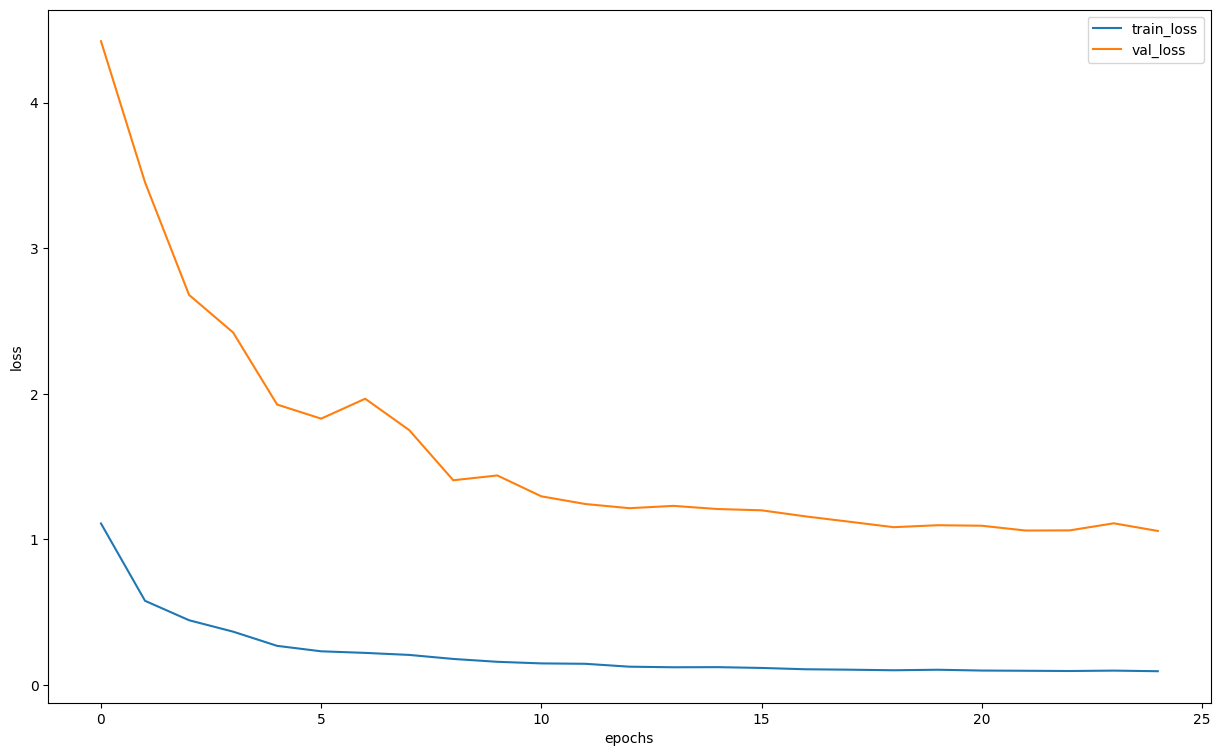

In [30]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [31]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [32]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [33]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [34]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [36]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.85


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

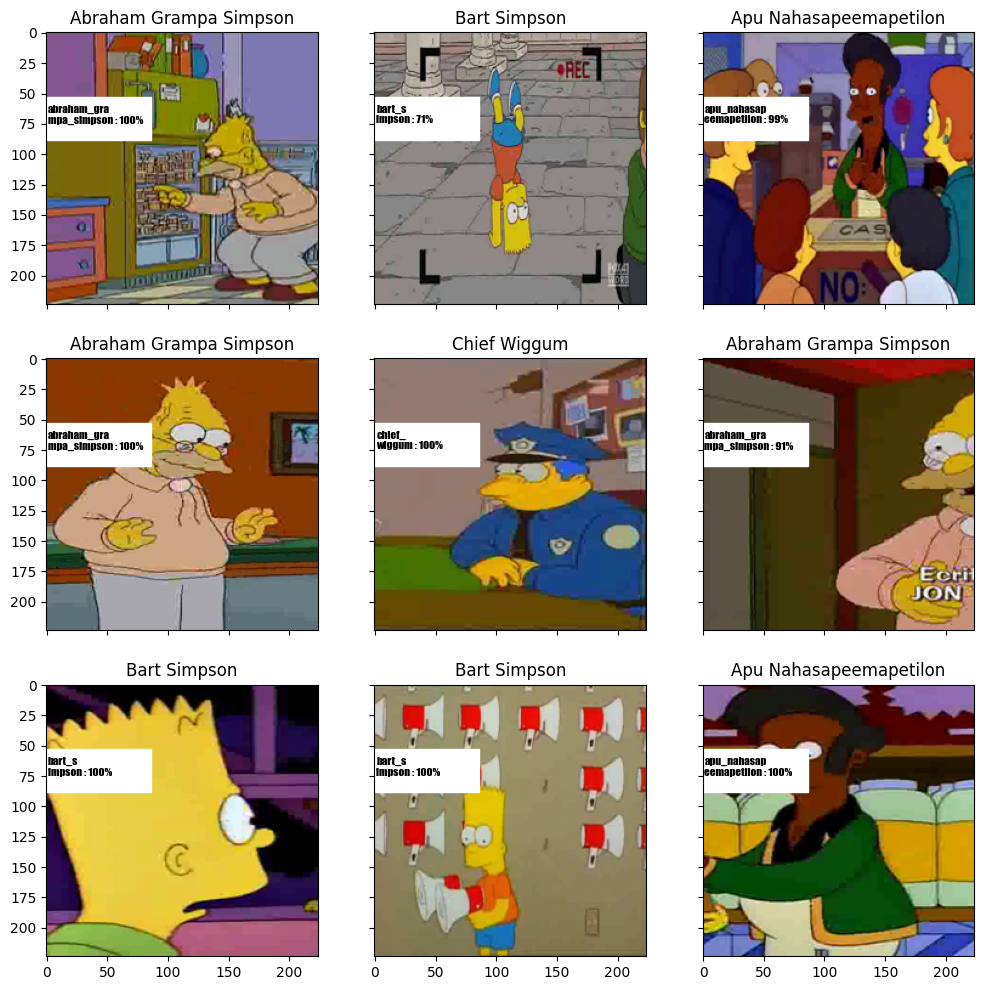

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [43]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})
my_submit.head()

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


![first_sub.png](first_sub.png)

In [44]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [46]:
torch.cuda.empty_cache()